#### 03 Classic ML Models for Pneumonia Detection

**Goal:**  
Extract meaningful features from chest X-ray images and train several classic machine learning models (SVM, Random Forest, Logistic Regression, etc.) to classify images as NORMAL or PNEUMONIA.

- Input: Preprocessed/augmented images
- Output: Trained ML models, performance metrics


In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [2]:
base_dir = '../chest_xray'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
val_dir = os.path.join(base_dir, 'val')
classes = ['NORMAL', 'PNEUMONIA']

IMG_SIZE = (128, 128)  # Smaller size for faster classic ML (not DL!)


In [3]:
def extract_features(img_path):
    # Read and resize image (grayscale)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, IMG_SIZE)
    img = img.astype('float32') / 255.0

    # Flatten the image
    pixels = img.flatten()
    
    # Histogram of pixel intensities (16 bins)
    hist = cv2.calcHist([img], [0], None, [16], [0,1]).flatten()
    
    # Mean and standard deviation
    mean = np.mean(img)
    std = np.std(img)
    
    # Concatenate all features
    features = np.concatenate([pixels, hist, [mean, std]])
    return features


In [4]:
def build_feature_dataset(data_dir, classes, n_max=None):
    X, y = [], []
    for label_idx, label in enumerate(classes):
        label_dir = os.path.join(data_dir, label)
        files = os.listdir(label_dir)
        if n_max:  # For speed/testing, limit number of images per class
            files = files[:n_max]
        for fname in tqdm(files, desc=f"Extracting {label}"):
            fpath = os.path.join(label_dir, fname)
            try:
                features = extract_features(fpath)
                X.append(features)
                y.append(label_idx)
            except:
                continue
    return np.array(X), np.array(y)

# Build features for train and validation data (skip test for now)
X_train, y_train = build_feature_dataset(train_dir, classes)
X_val, y_val = build_feature_dataset(val_dir, classes)


Extracting PNEUMONIA: 100%|██████████| 8/8 [00:00<00:00, 85.06it/s]


In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

# Dictionary to store models and predictions
models = {}

# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_scaled, y_train)
models['Logistic Regression'] = lr.predict(X_val_scaled)



In [9]:
# SVM
svm = SVC(kernel='rbf', probability=True)
svm.fit(X_train_scaled, y_train)
models['SVM'] = svm.predict(X_val_scaled)

In [10]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train_scaled, y_train)
models['Random Forest'] = rf.predict(X_val_scaled)

In [16]:
# Naive Bayes
nb = GaussianNB()
nb.fit(X_train_scaled, y_train)
models['Naive Bayes'] = nb.predict(X_val_scaled)


In [17]:
# Decision Tree
dt = DecisionTreeClassifier()
dt.fit(X_train_scaled, y_train)
models['Decision Tree'] = dt.predict(X_val_scaled)

In [18]:
# AdaBoost
ab = AdaBoostClassifier(n_estimators=100)
ab.fit(X_train_scaled, y_train)
models['AdaBoost'] = ab.predict(X_val_scaled)

In [19]:
# Gradient Boosting
gb = GradientBoostingClassifier(n_estimators=100)
gb.fit(X_train_scaled, y_train)
models['Gradient Boosting'] = gb.predict(X_val_scaled)

In [20]:
# Evaluate and print results for all models
summary = []

for name, y_pred in models.items():
    print(f"\n--- {name} ---")
    acc = accuracy_score(y_val, y_pred)
    cm = confusion_matrix(y_val, y_pred)
    report = classification_report(y_val, y_pred, target_names=classes, output_dict=True)
    print("Accuracy:", acc)
    print("Confusion Matrix:\n", cm)
    print(classification_report(y_val, y_pred, target_names=classes))
    summary.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": report['weighted avg']['precision'],
        "Recall": report['weighted avg']['recall'],
        "F1-score": report['weighted avg']['f1-score']
    })



--- Logistic Regression ---
Accuracy: 0.8125
Confusion Matrix:
 [[5 3]
 [0 8]]
              precision    recall  f1-score   support

      NORMAL       1.00      0.62      0.77         8
   PNEUMONIA       0.73      1.00      0.84         8

    accuracy                           0.81        16
   macro avg       0.86      0.81      0.81        16
weighted avg       0.86      0.81      0.81        16


--- SVM ---
Accuracy: 0.6875
Confusion Matrix:
 [[3 5]
 [0 8]]
              precision    recall  f1-score   support

      NORMAL       1.00      0.38      0.55         8
   PNEUMONIA       0.62      1.00      0.76         8

    accuracy                           0.69        16
   macro avg       0.81      0.69      0.65        16
weighted avg       0.81      0.69      0.65        16


--- Random Forest ---
Accuracy: 0.5625
Confusion Matrix:
 [[1 7]
 [0 8]]
              precision    recall  f1-score   support

      NORMAL       1.00      0.12      0.22         8
   PNEUMONIA       

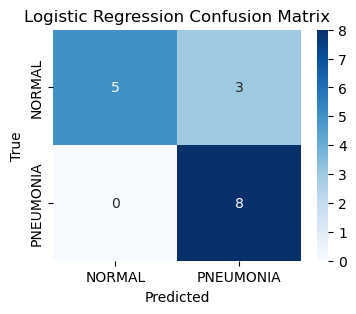

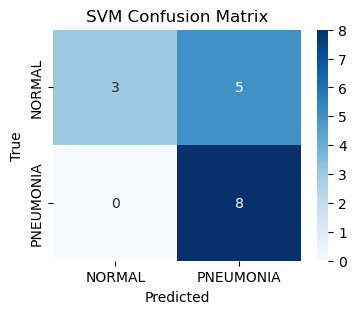

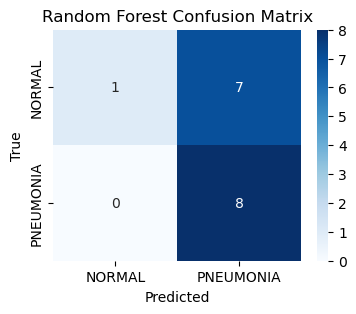

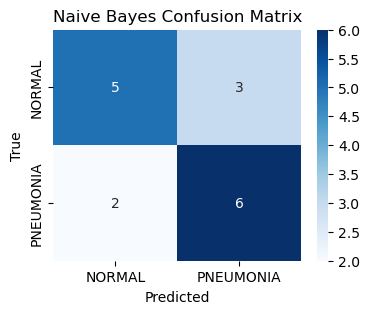

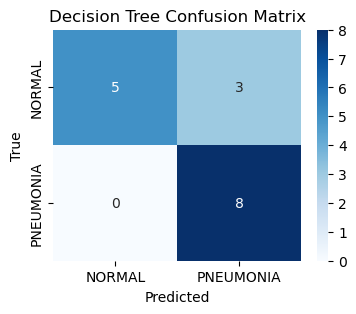

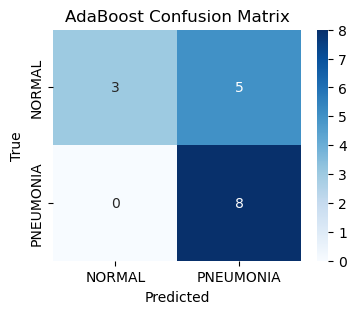

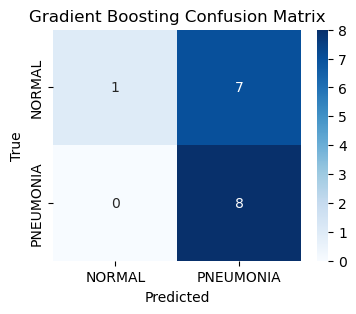

In [21]:
# Plot confusion matrix for each model
for name, y_pred in models.items():
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f"{name} Confusion Matrix")
    plt.show()


In [22]:
# Show a summary table of all models' performance
df_summary = pd.DataFrame(summary)
df_summary = df_summary.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)
df_summary


,Model,Accuracy,Precision,Recall,F1-score
0,Logistic Regression,0.8125,0.863636,0.8125,0.805668
1,Decision Tree,0.8125,0.863636,0.8125,0.805668
2,SVM,0.6875,0.807692,0.6875,0.653680
3,Naive Bayes,0.6875,0.690476,0.6875,0.686275
4,AdaBoost,0.6875,0.807692,0.6875,0.653680
5,Random Forest,0.5625,0.766667,0.5625,0.458937
6,Gradient Boosting,0.5625,0.766667,0.5625,0.458937


In [23]:
import joblib
import os
os.makedirs('saved_models/Classic_ML_Models', exist_ok=True)
# Save all trained models
joblib.dump(lr, 'saved_models/Classic_ML_Models/logistic_regression.pkl')
joblib.dump(svm, 'saved_models/Classic_ML_Models/svm.pkl')
joblib.dump(rf, 'saved_models/Classic_ML_Models/random_forest.pkl')
joblib.dump(knn, 'saved_models/Classic_ML_Models/knn.pkl')
joblib.dump(nb, 'saved_models/Classic_ML_Models/naive_bayes.pkl')
joblib.dump(dt, 'saved_models/Classic_ML_Models/decision_tree.pkl')
joblib.dump(ab, 'saved_models/Classic_ML_Models/adaboost.pkl')
joblib.dump(gb, 'saved_models/Classic_ML_Models/gradient_boosting.pkl')

print("All classic ML models saved ")


All classic ML models saved 
